# How to run clay over custom AOIs

This script shows in a few simple steps how the clay model can be run for custom AOIs and over custom date ranges.

## Download and open global list of MGRS tiles

In [1]:
import os
from pathlib import Path

# The repo home is our working directory.
wd = Path.cwd().parent
os.chdir(wd)
# Ensure data directories exist
Path("data/mgrs").mkdir(exist_ok=True)
Path("data/chips").mkdir(exist_ok=True)
Path("data/checkpoints").mkdir(exist_ok=True)
Path("data/embeddings").mkdir(exist_ok=True)

A full list of MGRS tiles has been created as part of the landcover based sampling strategy. The file is [sourced from a complete MGRS tile list](https://github.com/Clay-foundation/model/blob/main/scripts/landcover.sh#L7), and then [itersected with the WorldCover landcover](https://github.com/Clay-foundation/model/blob/main/scripts/landcover.py) layer, outputting the `mgrs_full.fgb` file that is used below.

In [2]:
import geopandas as gpd

! wget https://clay-mgrs-samples.s3.amazonaws.com/mgrs_full.fgb -O data/mgrs/mgrs_full.fgb

--2024-01-15 12:40:58--  https://clay-mgrs-samples.s3.amazonaws.com/mgrs_full.fgb
Resolving clay-mgrs-samples.s3.amazonaws.com (clay-mgrs-samples.s3.amazonaws.com)... 3.5.28.235, 54.231.165.153, 52.217.89.132, ...
Connecting to clay-mgrs-samples.s3.amazonaws.com (clay-mgrs-samples.s3.amazonaws.com)|3.5.28.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13787464 (13M) [binary/octet-stream]
Saving to: ‘data/mgrs/mgrs_full.fgb’

data/mgrs/mgrs_full 100%[===================>]  13.15M  4.30MB/s    in 3.1s    

2024-01-15 12:41:02 (4.30 MB/s) - ‘data/mgrs/mgrs_full.fgb’ saved [13787464/13787464]



In [3]:
mgrs = gpd.read_file("data/mgrs/mgrs_full.fgb")
mgrs

,Name,geometry
0,59CNK,"MULTIPOLYGON (((170.99885 -81.06088, 177.30316..."
1,59CNJ,"MULTIPOLYGON (((170.99872 -81.95638, 177.99281..."
2,58CEN,"MULTIPOLYGON (((164.99856 -82.85238, 172.85358..."
3,58CEP,"MULTIPOLYGON (((164.99872 -81.95638, 171.99281..."
4,60CVQ,"MULTIPOLYGON (((171.25220 -81.01644, 177.56261..."
...,...,...
56681,02CMR,"MULTIPOLYGON (((-176.23170 -80.12446, -170.488..."
56682,02CMQ,"MULTIPOLYGON (((-176.74780 -81.01644, -170.437..."
56683,01CEK,"MULTIPOLYGON (((-177.00115 -81.06088, -170.696..."
56684,01CEJ,"MULTIPOLYGON (((-177.00128 -81.95638, -170.007..."


In [4]:
mgrs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Create a Geopandas dataframe with AOI

This example uses a bounding box over the area around Puri, India.

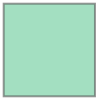

In [5]:
import geopandas as gpd
import pandas as pd
from shapely import box

aoi = gpd.GeoDataFrame(
    pd.DataFrame(["Puri"], columns=["Region"]),
    crs="EPSG:4326",
    geometry=[box(85.0503, 19.4949, 86.1042, 20.5642)],
)
aoi.geometry[0]

## Intersect the AOI with the MGRS tile layer

This will select the MGRS tiles that intersect with your AOI. The processing will then happen for each of the MGRS tiles. This will most likely provide slightly more data than the AOI itself, as the whole tile data will downloaded for each matched MGRS tile.

Store the intersected tiles in a file, it will be used by the `datacube.py` script.

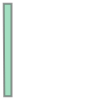

In [6]:
mgrs_aoi = mgrs.overlay(aoi)
# Rename the name column to use lowercase letters for the datacube script to
# pick upthe MGRS tile name.
mgrs_aoi = mgrs_aoi.rename(columns={"Name": "name"})
mgrs_aoi.geometry[2]

In [7]:
mgrs_aoi.to_file("data/mgrs/mgrs_aoi.fgb")
mgrs_aoi

,name,Region,geometry
0,45QTC,Puri,"POLYGON ((85.18408 19.79882, 85.05030 19.79707..."
1,45QUC,Puri,"POLYGON ((85.09075 19.79784, 85.08133 20.56420..."
2,45QVC,Puri,"POLYGON ((86.04484 19.80549, 86.04018 20.56420..."
3,45QVB,Puri,"POLYGON ((86.10420 19.89401, 86.10420 19.49490..."
4,45QTB,Puri,"POLYGON ((85.18307 19.88715, 85.18741 19.49490..."
5,45QUB,Puri,"POLYGON ((86.10420 19.89408, 86.10420 19.49490..."


## Use the datacube.py script to download imagery

Each run of th datacube script will take an index as input, which is the index of the MGRS tile within the input file. This is why we need to download the data in a loop.

A list of date ranges can be specified. The script will look for the least cloudy Sentinel-2 scene for each date range, and match Sentinel-1 dates near the identified Sentinel-2 dates.

The output folder can be specified as a local folder, or a bucket can be specified to upload the data to S3.

Note that for the script to run, a Microsoft Planetary Computer token needs to be set up, consult the [Planetary Computer SDK](https://github.com/microsoft/planetary-computer-sdk-for-python) documentation on how to set up the token.

In [8]:
# Print the help of the script to get a sense of the input parameters.
! python scripts/datacube.py --help

Usage: datacube.py [OPTIONS]

Options:
  --sample TEXT      Location of MGRS tile sample
  --index INTEGER    Index of MGRS tile from sample file that should be
                     processed
  --bucket TEXT      Specify the bucket for where to write the data.
  --subset TEXT      For debugging, subset x and y to this pixel window as a
                     commaseparated string of 4 integers.
  --localpath TEXT   If specified, this path will be used to write the tiles
                     locallyOtherwise a temp dir will be used.
  --dateranges TEXT  Comma separated list of date ranges, each provided as yy-
                     mm-dd/yy-mm-dd.
  --help             Show this message and exit.


By default, the datacube script will download all the data available for the each MGRS tile it processes. So the output might include imagery chips that are outside of the AOI specified.

To speed up processing in the example below, we use the subset argument to reduce each MGRS tile to a small pixel window. When subsetting, the script will only download a fraction of each MGRS tile. This will lead to discontinous datasets and should not be used in a real use case. Remove the subset argument when using the script for a real world application, where all the data should be downloaded for each MGRS tile.

In [9]:
for index, row in mgrs_aoi.iterrows():
    print(index, row)
    ! python scripts/datacube.py --sample data/mgrs/mgrs_aoi.fgb --subset 1500,1500,2524,2524 --localpath data/chips  --index {index} --dateranges 2020-01-01/2020-04-01,2021-06-01/2021-09-15

0 name                                                    45QTC
Region                                                   Puri
geometry    POLYGON ((85.1840761005 19.798817712, 85.0503 ...
Name: 0, dtype: object
Starting algorithm for MGRS tile 45QVB with index 0
Processing data for date range 2020-01-01/2020-04-01
Found 29 Sentinel-2 items
EPSG code based on Sentinel-2 item:  32645
Searching S1 in date range 2020-03-27/2020-04-02
Found 1 Sentinel-1 items
Most overlapped orbit:  descending
Found 1 DEM items
/home/tam/apps/miniforge3/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/tam/apps/miniforge3/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWar

## Create the embeddings for each training chip

The checkpoints can be accessed directly from huggingface at https://huggingface.co/made-with-clay/Clay.

The following command will automatically download and cache the model weights and run the model to create the embeddings.

In [10]:
! wandb disabled
! python trainer.py predict --ckpt_path=https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt \
                            --trainer.precision=16-mixed \
                            --data.data_dir=/home/tam/Desktop/aoitiles \
                            --data.batch_size=2 \
                            --data.num_workers=8

W&B disabled.
Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Seed set to 42
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

Total number of chips: 28
Restoring states from the checkpoint path at https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt
Downloading: "https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt" to /home/tam/.cache/torch/hub/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt
100%|████████████████████████████████████████| 487